In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Sistema de recomendación basado en contenido: Parte II

## Contexto

En el notebook anterior desarrollamos el primer sistema de recomendación basado en contenido: este tomaba la sinopsis de la película y a partir de ahí tomaba su vocabulario para comparar con otras películas. Si bien las recomendaciones mejoraron bastante con respecto al **sistema de recomendación basado en conocimiento** desarrollado anteriormente aún sufría de **ciertos problemas con respecto a las palabras**. 

Un claro ejemplo se presentó cuando en el final del notebook anterior pedimos recomendaciones para la película **"Rocky IV"** y si bien devolvió películas parecidas (sus secuelas y precuelas), habían algunas que no tenían en lo absoluto que ver con **la saga Rocky** pero tenían justamente la palabra **"Rocky"** en su sinopsis. 

Ahora para arreglar este proeblema (o por lo menos intentarlo) voy a generar un segundo sistema de recomendación basado en contenido pero que esta vez tome en cuenta más datos acerca de la película, tales como el director, los actores principales, su año de estreno, entre otras cosas. Todo esto con el propósito de ver una mejora significativa en las recomendaciones y ver como se comporta.

## Carga de los datos

Vamos a partir desde donde lo dejamos y para eso voy a cargar el dataframe filtrado con películas entre los años 1980 y 2000 que usamos anteriormente:

In [2]:
#Importo las librerías a usar
from utils.paths import crear_funcion_directorio
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo el dataset
df_metadata = pd.read_csv(data_dir("processed", "movies_metadata_filtered_2.csv"))

Siguiendo en línea con lo que planteaba anteriormente en la parte de **contexto** voy a cargar unos dataframes que tienen información más detallada sobre las películas y que servirán para mejorar el sistema de recomendación:

In [3]:
df_credits = pd.read_csv(data_dir("raw", "credits.csv"))
df_key = pd.read_csv(data_dir("raw", "keywords.csv"))

Vemos la información de ambos:

In [4]:
df_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [5]:
df_key.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


Podemos ver que ambos tienen información más detallada sobre las películas, tales como el cast de la misma y el equipo de producción. Se puede ver también que esta información no está en un formato deseado, por lo tanto habrá que trabajar un poco con los datos.

## Preprocesando los datos

### Unificando los datos

Lo ideal sería juntar los dos dataframes **'df_key'** y  **'df_credits'** con el dataframe principal para así tener toda la información en un único lugar. Para abarcar esto podemos usar la columna **'id'** presente en los 3 dataframes para así hacer **un Join**, pero primero debemos verificar que los datos en la misma estén correctos:

In [6]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22316 entries, 0 to 22315
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         22316 non-null  object 
 1   genres        22316 non-null  object 
 2   runtime       22208 non-null  float64
 3   vote_average  22316 non-null  float64
 4   vote_count    22316 non-null  float64
 5   release_year  22316 non-null  float64
 6   overview      21828 non-null  object 
 7   id            22316 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


Podemos ver que la columna **'id'** en nuestro dataframe principal es de tipo **'object'**, cosa que no queremos y por lo tanto debemos convertirla a tipo entero: 

In [7]:
try:
    df_metadata['id'] = df_metadata['id'].astype(int)
except(Exception) as e:
    print(e)

Vemos que no podemos convertir la columna al tipo entero de primeras, por lo tanto debemos hacer algo de trabajo eliminando la información no deseada en esta misma:

In [8]:
from utils.functions import limpiar_ids

# Convierto los id´s no deseados a nulos
df_metadata['id'] = df_metadata['id'].apply(limpiar_ids)

# Elimino los valores nulos en 'id'
df_metadata = df_metadata[df_metadata['id'].notnull()]

Otra cosa antes de hacer el join es también convertir las columnas de **'id'** en **'df_key'** y  **'df_credits'** a tipo entero y además eliminar duplicados para evitar problemas:

In [9]:
# Convierto 'id' a tipo entero en ambos dfs
df_credits['id'] = df_credits['id'].astype(int)
df_key['id'] = df_key['id'].astype(int)

# Elimino los duplicados en ambos dfs
df_credits.drop_duplicates(inplace=True)
df_key.drop_duplicates(inplace=True)

Finalmente podemos juntar los 3 dataframes en uno solo:

In [10]:
df_metadata = df_metadata.merge(df_credits, on="id")
df_metadata = df_metadata.merge(df_key, on="id")

df_metadata.head()

,title,genres,runtime,vote_average,vote_count,release_year,overview,id,cast,crew,keywords
0,Toy Story,"['Animation', 'Comedy', 'Family']",81.0,7.7,5415.0,1995.0,"Led by Woody, Andy's toys live happily in his ...",862,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,Jumanji,"['Adventure', 'Fantasy', 'Family']",104.0,6.9,2413.0,1995.0,When siblings Judy and Peter discover an encha...,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,Grumpier Old Men,"['Romance', 'Comedy']",101.0,6.5,92.0,1995.0,A family wedding reignites the ancient feud be...,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",127.0,6.1,34.0,1995.0,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,Father of the Bride Part II,['Comedy'],106.0,5.7,173.0,1995.0,Just when George Banks has recovered from his ...,11862,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


### Convirtiendo la información a un formato accesible

In [11]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22320 entries, 0 to 22319
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         22320 non-null  object 
 1   genres        22320 non-null  object 
 2   runtime       22212 non-null  float64
 3   vote_average  22320 non-null  float64
 4   vote_count    22320 non-null  float64
 5   release_year  22320 non-null  float64
 6   overview      21832 non-null  object 
 7   id            22320 non-null  int64  
 8   cast          22320 non-null  object 
 9   crew          22320 non-null  object 
 10  keywords      22320 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1.9+ MB


Ahora que tenemos toda la información necesaria en un solo dataframe debemos llevarla a una forma en que pueda hacer usable, más precisamente haremos lo siguiente:

* Convertiré **'keywords'** en una lista de cadenas en donde cada una es una palabra clave (similar a como hicimos con los géneros en el primer notebook). La cantidad de palabras claves que incluiremos en la lista despúes será definida según un número
* Convertiré **'cast'** en una lista de cadenas en donde cada una es el nombre de un actor, esta seguirá una estructura similar a **'keywords'**
* Convertiré **'crew'** en **'director'**, así solo nos quedaremos con el director de la película

Con estos cambios llevaremos los datos a la forma deseada y podremos generar el nuevo sistema de recomendación que deseamos. Estos cambios son para efectos prácticos y pueden cambiar en un futuro para tomar más features y hacer más profundo a nuestro sistema.

Primero debemos convertir a todos los features involucrados a su tipo correspondiente en Python:

In [12]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']

for feature in features:
    df_metadata[feature] = df_metadata[feature].apply(literal_eval)

Ahora paso a obtener la feature **'director'**, para eso analizamos la estructura del diccionario donde puedo conseguirla:

In [13]:
df_metadata.iloc[0]['crew'][:2]

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'}]

Podemos ver que en la clave **'job'** del diccionario está indicado que rol cumplia cada persona en la producción de la película, por ahora nos interesa quedarnos con el director pero esto luego podría servirnos para involucrar más personas en la información de la película. 

Ahora paso a generar la columna **'director'**:

In [14]:
from utils.functions import obtener_director

df_metadata['director'] = df_metadata['crew'].apply(obtener_director)

df_metadata['director'].head()

0      John Lasseter
1       Joe Johnston
2      Howard Deutch
3    Forest Whitaker
4      Charles Shyer
Name: director, dtype: object

Vemos que efectivamente se guardaron los nombres de los directores en la columna, ahora el siguiente paso es trabajar **'cast'** y **'keywords'**.

Tanto **'cast'** como **'keywords'** son listas de diccionarios también y nosotros queremos quedarnos con cierta cantidad de nombres en ambos casos, es decir que debemos extraer la cantidad de nombres que queremos de la clave **'name'**. Vamos a usar una función que haga todo eso y que a modo de práctica se traiga **los primeros 5 nombres en cada caso**:

In [15]:
from utils.functions import generar_lista

cant_nombres = 5

df_metadata['cast'] = df_metadata['cast'].apply(generar_lista, args=(cant_nombres,))
df_metadata['keywords'] = df_metadata['keywords'].apply(generar_lista, args=(cant_nombres,))

# Me quedo también con los primeros 5 generos en 'genres'
df_metadata['genres'] = df_metadata['genres'].apply(lambda x: x[:cant_nombres])

Ahora vamos a ver como quedó el dataframe luego de aplicados los cambios:

In [16]:
df_metadata[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[jealousy, toy, boy, friendship, friends]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,"[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]"
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,"[baby, midlife crisis, confidence, aging, daug...",[Comedy]


Vemos que todo funcionó como se deseaba y que ahora tenemos nuestros features en la forma que queremos.

Ahora en los próximos pasos vamos a usar un vectorizador para generar las recomendaciones, pero hay que recordar como funciona este: separa palabras que no sean conectores y las guarda en un "vocabulario". Este comportamiento puede no ser el deseado cuando **tenemos ahora nombres de actores y directores**, ya que podemos pensar en **Ryan Gosling y Ryan Reynolds** los cuales son actores distintos pero al vectorizador detectar el primer nombre **'Ryan'** los tratará como una misma entidad.

Por lo tanto hay que usar una función que haga el trabajo de llevar los nombres a minuculas y unirlos para que formen una sola palabra a ojos del vectorizador. Por lo tanto pasamos a aplicarla:

In [17]:
from utils.functions import procesar_nombre

for columna in ['cast', 'director', 'keywords', 'genres']:
    df_metadata[columna] = df_metadata[columna].apply(procesar_nombre)

Ahora verificamos de vuelta como están nuestras columnas:

In [18]:
df_metadata[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Toy Story,"[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,"[jealousy, toy, boy, friendship, friends]","[animation, comedy, family]"
1,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst, br...",joejohnston,"[boardgame, disappearance, basedonchildren'sbo...","[adventure, fantasy, family]"
2,Grumpier Old Men,"[waltermatthau, jacklemmon, ann-margret, sophi...",howarddeutch,"[fishing, bestfriend, duringcreditsstinger, ol...","[romance, comedy]"
3,Waiting to Exhale,"[whitneyhouston, angelabassett, lorettadevine,...",forestwhitaker,"[basedonnovel, interracialrelationship, single...","[comedy, drama, romance]"
4,Father of the Bride Part II,"[stevemartin, dianekeaton, martinshort, kimber...",charlesshyer,"[baby, midlifecrisis, confidence, aging, daugh...",[comedy]


### Juntando los metadatos

En el notebook anterior, cuando trabajamos con la sinopsis de las películas **'overview'** esta columna venía como una larga cadena de texto, ahora que tenemos todas nuestras features de interés en el formato que deseamos deberíamos lograr lo mismo **uniéndolas a todas**. Para eso voy a usar una función que logre obtener esta cadena en una sola columna llamada **'features_soup'** para así luego vectorizarla:

In [19]:
from utils.functions import juntar_features

df_metadata['features_soup'] = df_metadata.apply(juntar_features, axis=1)

#Vemos por pantalla como se ve está columna
df_metadata['features_soup'].iloc[0]

'jealousy toy boy friendship friends tomhanks timallen donrickles jimvarney wallaceshawn johnlasseter animation comedy family'

Ahora con nuestra columna que reune todos los metadatos relevantes de la película estamos en una buena posición para **vectorizar esta información y calcular el puntaje de similitud coseno**.

## Construyendo el sistema de recomendación

Lo siguiente es vectorizar la columna **'features_soup'** para poder calcular el puntaje de similitud coseno, pero en este caso **el vectorizador que se usará es distinto**. Usaré el **CountVectorizer** que le asigna pesos iguales a todas las palabras, esto porque si uso de vuelta el **TF-IDF Vectorizer** este va a penalizar a actores y directores que estuvieron en varias películas, ya que va a detectar el nombre de los mismos **como palabras comunes**. 

Por lo tanto proceso a usar **scikit-learn** para vectorizar la información:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')

count_matrix = count.fit_transform(df_metadata['features_soup'])

Y ahora al usar un **CountVectorizer** estamos forzados a usar directamente la función que calcula el puntaje de similitud coseno, a diferencia de lo que habíamos hecho antes únicamente calculando el producto punto:

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

Y ahora usamos de vuelta la función que nos sirvió como sistema de recomendación en el notebook anterior:

In [22]:
from utils.recommenders import recomendar_peli

#Reseteo el indice del dataframe
df_metadata.reset_index(drop=True, inplace=True)

recomendar_peli("Rocky IV", cosine_sim, df_metadata)

,Pelicula,Similitud
1911,Rocky III,0.642857
8134,Rocky Balboa,0.483046
1913,Rocky V,0.444750
8846,Rambo,0.276026
1387,Ill Gotten Gains,0.267261
11192,The Expendables,0.267261
13462,Sundome,0.267261
15017,Norwegian Ninja,0.267261
15646,Home Sweet Home,0.267261
18257,Yolngu Boy,0.267261


Volví a probar obtener recomendaciones para la película **Rocky IV** y cambiaron drásticamente el tipo de recomendaciones, podemos ver que aparecen películas como **Rambo** la cual es protagonizada por **Sylvester Stallone**, por lo cual podríamos intuir que su nombre tuvo mucho peso en el vocabulario, cosa que queríamos.

Como buena práctica, podemos ver cuales fueron las palabras de mayor peso según el vectorizador que usamos:

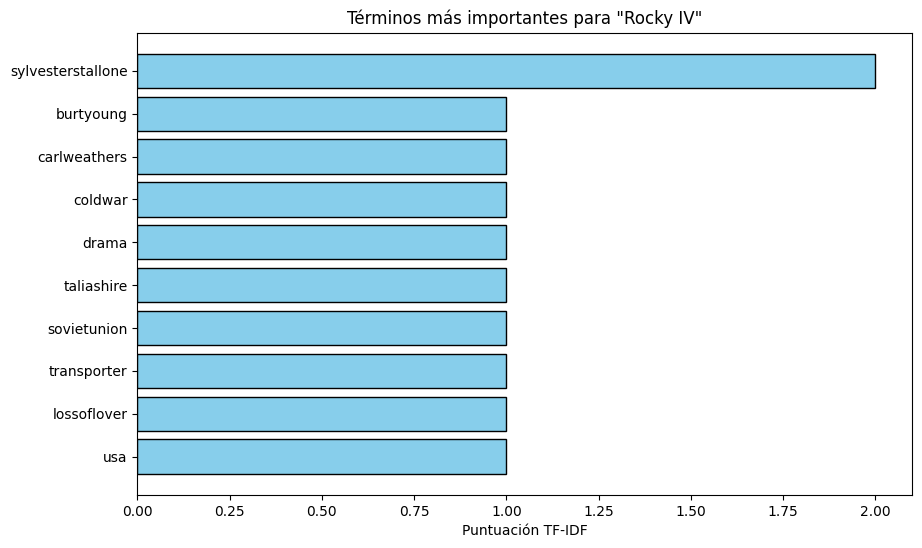

In [23]:
from utils.functions import plot_important_terms_for_movie

plot_important_terms_for_movie("Rocky IV",df_metadata, count, count_matrix)